In [1]:
import os
import numpy as np
import pandas as pd
import time
import warnings
from matplotlib import pyplot as plt

from sklearn.neural_network import MLPClassifier
import sklearn.metrics
from sklearn.metrics import balanced_accuracy_score

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

### Data Preprocessing

Contents of train_x.csv: arr of shape (2102, 784)
Contents of valid_x.csv: arr of shape (600, 784)


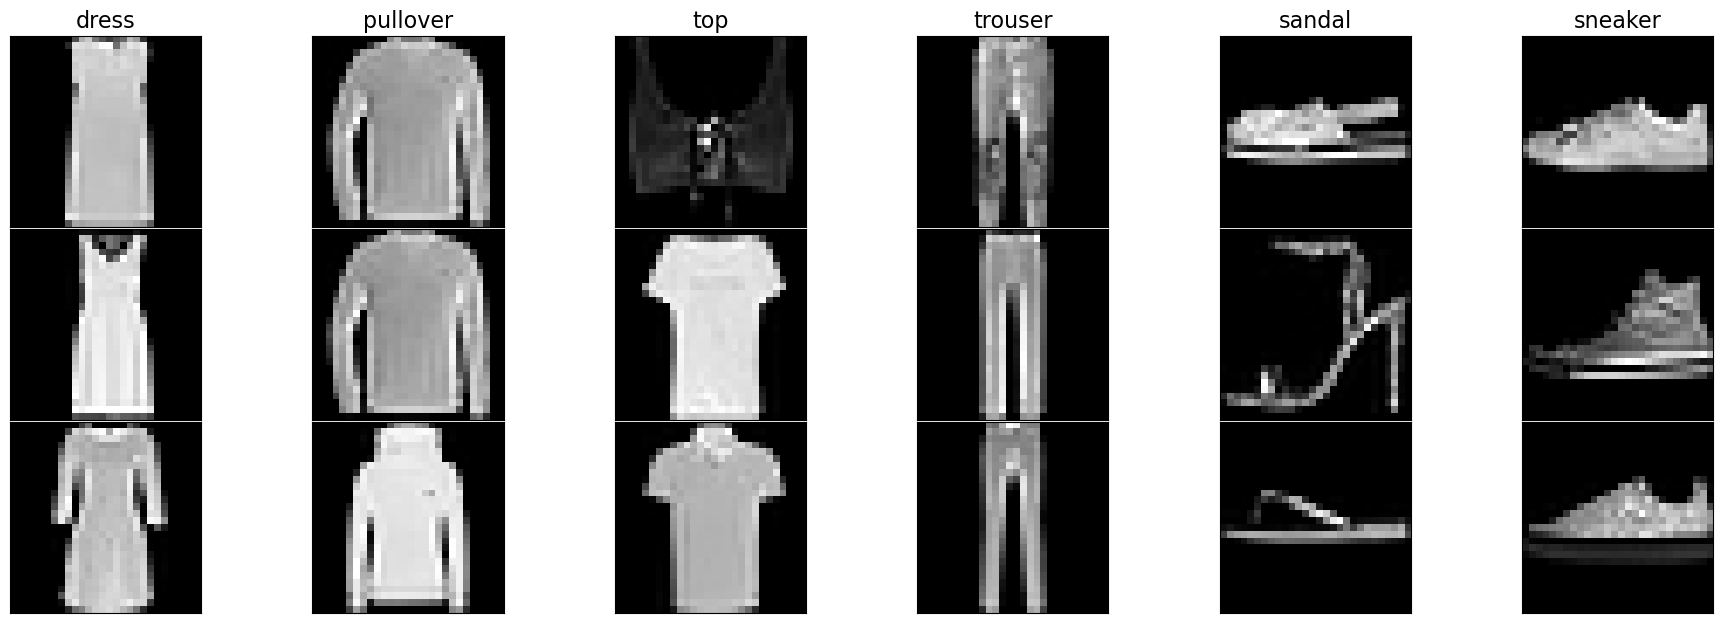

In [2]:
%run load_and_plot_data.py

In [3]:
train_y_df, valid_y_df

(     class_name  class_uid
 0      pullover          2
 1           top          0
 2         dress          3
 3        sandal          5
 4      pullover          2
 ...         ...        ...
 2097     sandal          5
 2098     sandal          5
 2099     sandal          5
 2100     sandal          5
 2101     sandal          5
 
 [2102 rows x 2 columns],
     class_name  class_uid
 0        dress          3
 1        dress          3
 2        dress          3
 3        dress          3
 4        dress          3
 ..         ...        ...
 595    sneaker          7
 596    sneaker          7
 597        top          0
 598        top          0
 599    trouser          1
 
 [600 rows x 2 columns])

In [4]:
temp = np.array(train_y_df)
count_array = temp[:,1]
count_train = np.unique(count_array, return_counts = True)

temp = np.array(valid_y_df)
count_array = temp[:,1]
count_valid = np.unique(count_array, return_counts = True)

In [5]:
count_train, count_valid

((array([0, 1, 2, 3, 5, 7], dtype=object),
  array([  1,   1, 100, 400, 800, 800], dtype=int64)),
 (array([0, 1, 2, 3, 5, 7], dtype=object),
  array([100, 100, 100, 100, 100, 100], dtype=int64)))

In [6]:
train_y = np.array(train_y_df['class_uid'])
train_y.shape

(2102,)

In [7]:
train_x.shape, train_x[0].dtype

((2102, 784), dtype('int64'))

### Data Duplication

In [8]:
# selecting the tops and trousers
top_x = train_x[train_y == 0]
trouser_x = train_x[train_y == 1]
top_y = train_y[train_y == 0]
trouser_y = train_y[train_y == 1]

print(top_x.shape, trouser_x.shape)
print(top_y.shape, trouser_y.shape)

(1, 784) (1, 784)
(1,) (1,)


In [9]:
# selecting the dresses
dress_x = train_x[train_y == 3]
dress_y = train_y[train_y == 3]

In [10]:
# selecting pullovers
pullover_x = train_x[train_y == 2]
pullover_y = train_y[train_y == 2]

#### duplicating tops/trousers

In [11]:
# duplicated top and trouser arrays
top_x_array = np.tile(top_x, (1499, 1))
trouser_x_array = np.tile(trouser_x, (1199, 1))

top_y_array = np.tile(top_y, (1499))
trouser_y_array = np.tile(trouser_y, (1199))

print(top_x_array.shape, trouser_x_array.shape)
print(top_y_array.shape, trouser_y_array.shape)

(1499, 784) (1199, 784)
(1499,) (1199,)


#### Randomly Duplicating

In [12]:
#randomly duplicating dresses
dress_dupe_in = np.random.choice(len(dress_x), size = 400, replace = True)
dress_dupe_x = dress_x[dress_dupe_in]
dress_dupe_y = dress_y[dress_dupe_in]

In [13]:
dress_x_array = dress_dupe_x
dress_y_array = dress_dupe_y

In [14]:
#randomly duplicating pullovers 
pull_dupe_in = np.random.choice(len(pullover_x), size = 700, replace = True)
#print(dress_duplicates_in)
pull_dupe_x = pullover_x[pull_dupe_in]
pull_dupe_y = pullover_y[pull_dupe_in]
#count = np.unique(dress_duplicates_x, return_counts = True)
#count

In [15]:
pullover_x_array = pull_dupe_x
pullover_y_array = pull_dupe_y

In [16]:
## Adding tops, trousers, and dresses to train_x
temp = np.vstack((train_x, top_x_array))
print(temp.shape)

temp2 = np.vstack((temp, dress_x_array))
print(temp2.shape)

temp3 = np.vstack((temp2, pullover_x_array))
print(temp3.shape)

duplicated_train_x = np.vstack((temp3, trouser_x_array))
print(duplicated_train_x.shape)


t = np.hstack((train_y, top_y_array))
t2 = np.hstack((t, dress_y_array))
t3 = np.hstack((t2, pullover_y_array))
duplicated_train_y = np.hstack((t3, trouser_y_array))
print(top_y_array.shape, dress_y_array.shape, trouser_y_array.shape, pullover_y_array.shape)

print(duplicated_train_x.shape, duplicated_train_y.shape)

(3601, 784)
(4001, 784)
(4701, 784)
(5900, 784)
(1499,) (400,) (1199,) (700,)
(5900, 784) (5900,)


In [17]:
valid_y = np.array(valid_y_df['class_uid'])
valid_y.shape, duplicated_train_y.shape

((600,), (5900,))

In [18]:
### Normalizing data

scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(duplicated_train_x)
normed_train_x = scaler.transform(duplicated_train_x)
normed_valid_x = scaler.transform(valid_x)
normed_train_x.shape

(5900, 784)

In [19]:
mlp = MLPClassifier(
            activation='relu',
            solver='lbfgs',
            batch_size = 10000,
            learning_rate='adaptive', 
            early_stopping = True,
            momentum=0.0
            )

In [51]:
random_states = np.random.randint(1, 1000, size=4)

In [61]:
mlp_hyperparameter_grid = {
    'hidden_layer_sizes': [(50,), (128,)],  
    'alpha': np.logspace(2, -7, 20),
    'max_iter': [15, 25],
    'random_state': random_states,
    'n_iter_no_change': [10, 25]
    #'solver': ['lbfgs'], 
    #'learning_rate': ['constant', 'adaptive'],  
}

# mlp_hyperparameter_grid = dict(
#     hidden_layer_sizes = [(50,), (75,), (100,), (150,)],
#     max_iter= [5, 10, 15, 25, 50, 100, 500],
#     random_state = [111], 
#     learning_rate_init= [0.001], 
#     n_iter_no_change=[5, 10, 25, 50, 100],
#     alpha=[100, 10, 1]
#     )

### fit on train

In [62]:
xall = np.vstack([normed_train_x, normed_valid_x])
yall = np.hstack([duplicated_train_y, valid_y])

### splitter
valid_indicators_L = np.hstack([
    -1 * np.ones(duplicated_train_y.size), # -1 means never include this example in any test split
    0  * np.ones(valid_y.size), #  0 means include in the first test split (we count starting at 0 in python)
    ])
my_splitter = sklearn.model_selection.PredefinedSplit(valid_indicators_L)

In [70]:
mlp_searcher = sklearn.model_selection.GridSearchCV(estimator = mlp,
                                                    param_grid = mlp_hyperparameter_grid,
                                                    scoring = 'balanced_accuracy',
                                                    cv = my_splitter,
                                                    return_train_score = True,
                                                    refit=False, verbose=5
                                                   )

In [71]:
start_time_sec = time.time()
mlp_searcher.fit(xall, yall)
elapsed_time_sec = time.time() - start_time_sec

Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV 1/1] END alpha=100, hidden_layer_sizes=(50,), max_iter=15, n_iter_no_change=10, random_state=111;, score=(train=0.949, test=0.878) total time=   0.5s


C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [65]:
print(elapsed_time_sec)

mlp_searcher_result = pd.DataFrame(mlp_searcher.cv_results_).copy()
# [mlp_searcher_result.mean_test_score, mlp_searcher_result.params]

793.2507503032684


### Plot hyperparameter search results
TO DO

### Best hyperparameters to get balanced accuracy on validation/test

In [66]:
mlp_searcher.best_params_

{'alpha': 3.79269019073225,
 'hidden_layer_sizes': (50,),
 'max_iter': 25,
 'n_iter_no_change': 10,
 'random_state': 520}

In [72]:
## When searcher is used

best_mlp = mlp 
best_param = mlp_searcher.best_params_
best_mlp.set_params(**best_param)
best_mlp.fit(normed_train_x, duplicated_train_y)

C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=100, batch_size=10000, early_stopping=True,
              hidden_layer_sizes=(50,), learning_rate='adaptive', max_iter=15,
              momentum=0.0, random_state=111, solver='lbfgs')

In [73]:
# normed_valid_x = sklearn.preprocessing.normalize(valid_x, norm = 'max', axis = 1)

pred_y = best_mlp.predict(normed_valid_x)
best_mlp_BAcc = balanced_accuracy_score(valid_y, pred_y)
best_mlp_BAcc

0.8783333333333333

In [42]:
pred_y.shape

(600,)

### Trying to figure out y_pred vs y_true error


In [43]:
#print(valid_y)
#print(pred_y)


count_pred = pred_y
count_pr_2 = np.unique(count_pred, return_counts = True)

count_val = valid_y
count_valid = np.unique(count_val, return_counts = True)

print(count_valid)
print(count_pr_2)

(array([0, 1, 2, 3, 5, 7], dtype=int64), array([100, 100, 100, 100, 100, 100], dtype=int64))
(array([0, 1, 2, 3, 5, 7], dtype=int64), array([ 64,  90, 116, 129,  86, 115], dtype=int64))


### Confusion Matrix

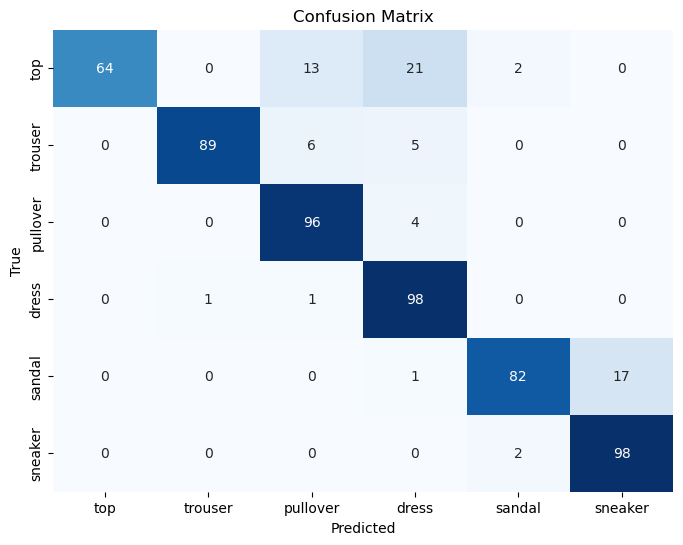

In [45]:
conf_matrix = confusion_matrix(valid_y, pred_y)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['top', 'trouser', 'pullover', 'dress', 'sandal', 'sneaker'],
            yticklabels=['top', 'trouser', 'pullover', 'dress', 'sandal', 'sneaker'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Alpha Search

In [ ]:
# {'alpha': 100,
#  'hidden_layer_sizes': (50,),
#  'max_iter': 15,
#  'n_iter_no_change': 10,
#  'random_state': 111}

In [77]:
mlp_hyperparameter_grid = {
    'hidden_layer_sizes': [(50,)],  
    'alpha': [500, 100, 50, 10, 1, 0.001],
    'max_iter': [15],
    'random_state': [111],
    'n_iter_no_change': [10]
    #'solver': ['lbfgs'], 
    #'learning_rate': ['constant', 'adaptive'],  
}


In [78]:
mlp_searcher = sklearn.model_selection.GridSearchCV(estimator = mlp,
                                                    param_grid = mlp_hyperparameter_grid,
                                                    scoring = 'balanced_accuracy',
                                                    cv = my_splitter,
                                                    return_train_score = True,
                                                    refit=False, verbose=5
                                                   )

In [79]:
start_time_sec = time.time()
mlp_searcher.fit(xall, yall)
elapsed_time_sec = time.time() - start_time_sec

Fitting 1 folds for each of 6 candidates, totalling 6 fits


C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/1] END alpha=500, hidden_layer_sizes=(50,), max_iter=15, n_iter_no_change=10, random_state=111;, score=(train=0.916, test=0.713) total time=   0.5s


C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/1] END alpha=100, hidden_layer_sizes=(50,), max_iter=15, n_iter_no_change=10, random_state=111;, score=(train=0.949, test=0.878) total time=   0.5s


C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/1] END alpha=50, hidden_layer_sizes=(50,), max_iter=15, n_iter_no_change=10, random_state=111;, score=(train=0.948, test=0.823) total time=   0.6s


C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/1] END alpha=10, hidden_layer_sizes=(50,), max_iter=15, n_iter_no_change=10, random_state=111;, score=(train=0.961, test=0.750) total time=   0.5s


C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/1] END alpha=1, hidden_layer_sizes=(50,), max_iter=15, n_iter_no_change=10, random_state=111;, score=(train=0.959, test=0.732) total time=   0.5s
[CV 1/1] END alpha=0.001, hidden_layer_sizes=(50,), max_iter=15, n_iter_no_change=10, random_state=111;, score=(train=0.960, test=0.728) total time=   0.5s


C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [80]:
mlp_searcher_result = pd.DataFrame(mlp_searcher.cv_results_).copy()
mlp_searcher_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_hidden_layer_sizes,param_max_iter,param_n_iter_no_change,param_random_state,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,0.635900,0.0,0.002999,0.0,500,"(50,)",15,10,111,"{'alpha': 500, 'hidden_layer_sizes': (50,), 'm...",0.713333,0.713333,0.0,6,0.915833,0.915833,0.0
1,0.634376,0.0,0.004003,0.0,100,"(50,)",15,10,111,"{'alpha': 100, 'hidden_layer_sizes': (50,), 'm...",0.878333,0.878333,0.0,1,0.948542,0.948542,0.0
2,0.701821,0.0,0.003996,0.0,50,"(50,)",15,10,111,"{'alpha': 50, 'hidden_layer_sizes': (50,), 'ma...",0.823333,0.823333,0.0,2,0.947500,0.947500,0.0
3,0.591238,0.0,0.004003,0.0,10,"(50,)",15,10,111,"{'alpha': 10, 'hidden_layer_sizes': (50,), 'ma...",0.750000,0.750000,0.0,3,0.961458,0.961458,0.0
4,0.576722,0.0,0.003996,0.0,1,"(50,)",15,10,111,"{'alpha': 1, 'hidden_layer_sizes': (50,), 'max...",0.731667,0.731667,0.0,4,0.959375,0.959375,0.0
5,0.591867,0.0,0.004001,0.0,0.001,"(50,)",15,10,111,"{'alpha': 0.001, 'hidden_layer_sizes': (50,), ...",0.728333,0.728333,0.0,5,0.959583,0.959583,0.0


In [84]:
max_iter = mlp_searcher_result['param_max_iter']
alpha = mlp_searcher_result['param_alpha']
random_state = mlp_searcher_result['param_random_state']
valid = mlp_searcher_result['mean_test_score']
train = mlp_searcher_result['mean_train_score']
layer_siz = mlp_searcher_result['param_hidden_layer_sizes']

In [85]:
data = {"Alpha" : alpha,
        "Hidden Layer Size" : layer_siz,
       "Max Iteration": max_iter,
       "Validation Accuracy": valid,
       "Training Score": train}

In [86]:
pd.DataFrame(data)

,Alpha,Hidden Layer Size,Max Iteration,Validation Accuracy,Training Score
0,500,"(50,)",15,0.713333,0.915833
1,100,"(50,)",15,0.878333,0.948542
2,50,"(50,)",15,0.823333,0.947500
3,10,"(50,)",15,0.750000,0.961458
4,1,"(50,)",15,0.731667,0.959375
5,0.001,"(50,)",15,0.728333,0.959583
